# An example using Feature weighted ECM clustering


In [10]:
## Importing
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import matplotlib.pyplot as plt
from evclust.ecm import ecm
from evclust.fwecm import fwecm
from evclust.utils import ev_summary, ev_plot, ev_pcaplot
import pandas as pd
from sklearn.metrics import adjusted_rand_score, silhouette_score


In [3]:
# Non-specificity values
def calculate_non_specificity(cluster_model):
    m = cluster_model['mass']
    F = cluster_model['F']
    c = F.shape[1]
    card = np.sum(F[1:F.shape[0], :], axis=1)

    log_card = np.log2(card)
    tmp = np.tile(log_card.transpose(), (m.shape[0], 1))
    m_log_card = m[:, :-1] * tmp

    mvide = m[:, -1][:, np.newaxis]
    tmp2 = mvide * np.log2(c)
    tmp3 = np.tile(tmp2, (1, m.shape[1] - 1))

    non_specificity = m_log_card + tmp3
    object_non_specificity = np.sum(non_specificity, axis=1)

    print(f"Maximum Non-specificity value: {max(object_non_specificity)}")
    print(f"Minimum Non-specificity value: {min(object_non_specificity)}")
    print(f"Average Non-specificity value: {np.mean(object_non_specificity)}")

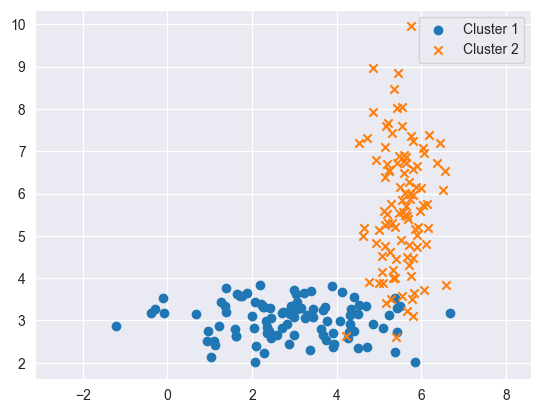

In [5]:
## Generating data set
# Number of samples in the cluster
num_samples = 100

# Mean and covariance for the cluster
mean = [3, 3]
covariance1 = [[2, 0],
               [0, 0.2]]  # Wider along x-axis, narrower along y-axis
cluster1 = np.random.multivariate_normal(mean, covariance1, num_samples)
cluster1 = np.c_[cluster1, np.zeros((cluster1.shape[0], 1))]

mean = [5.5, 5.5]
covariance2 = [[0.2, 0],
               [0, 2]]  # Wider along y-axis, narrower along x-axis
cluster2 = np.random.multivariate_normal(mean, covariance2, num_samples)
cluster2 = np.c_[cluster2, np.ones((cluster2.shape[0], 1))]

dataset = np.vstack([cluster1, cluster2])
df = pd.DataFrame(data=dataset[:, :-1], columns=['X-axis', 'Y-axis'])
plt.scatter(cluster1[:, 0], cluster1[:, 1], marker='o', label='Cluster 1')
plt.scatter(cluster2[:, 0], cluster2[:, 1], marker='x', label='Cluster 2')
# plt.xlabel('X-axis')
# plt.ylabel('Y-axis')
# plt.title('2D Dataset with two clusters - Wide x-Axis, Narrow y-Axis')
plt.legend()
plt.axis('equal')
plt.show()

[1, 279.11710298528857]
[2, 273.10170172572384]
[3, 272.2655837066044]
[4, 272.0933521447972]
[5, 272.033366498385]
[6, 272.00675974467515]
[7, 271.99422269160124]
[8, 271.988244148572]
[9, 271.98538678385006]
[10, 271.984020249915]
[11, 271.9833662533022]
[  0.         271.98336625 271.98336625]
[1, 279.11710298528857]
[2, 273.10170172572384]
[3, 272.2655837066044]
[4, 272.0933521447973]
[5, 272.033366498385]
[6, 272.00675974467515]
[7, 271.99422269160124]
[8, 271.988244148572]
[9, 271.98538678385006]
[10, 271.984020249915]
[11, 271.9833662533022]
[  1.         271.98336625 271.98336625]
[1, 279.11710298528857]
[2, 273.10170172572384]
[3, 272.2655837066044]
[4, 272.0933521447972]
[5, 272.033366498385]
[6, 272.00675974467515]
[7, 271.99422269160124]
[8, 271.988244148572]
[9, 271.98538678385006]
[10, 271.984020249915]
[11, 271.9833662533022]
[  2.         271.98336625 271.98336625]
[1, 279.11710298528857]
[2, 273.10170172572384]
[3, 272.2655837066044]
[4, 272.0933521447972]
[5, 272.0333

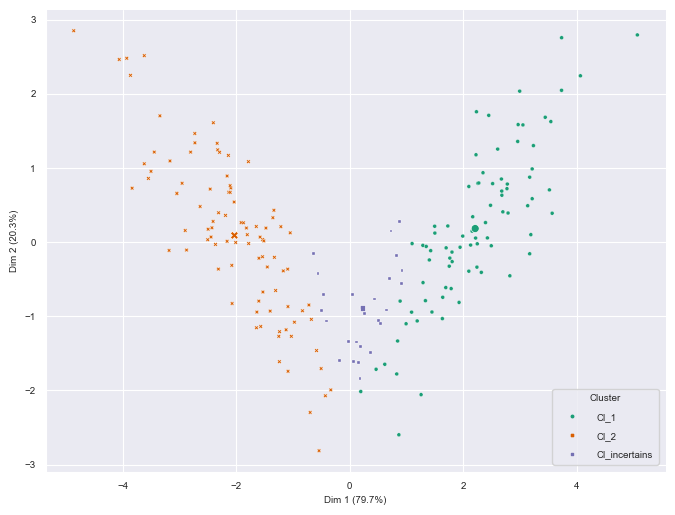

Adjusted Rand Index (ARI): 0.8642177453445731
Silhouette Index (SI): 0.5362372059879225
Maximum Non-specificity value: 2.202176669326351
Minimum Non-specificity value: 0.0013432092192850408
Average Non-specificity value: 0.9332356464967302


In [33]:
# Traditional ECM clustering
model = ecm(x=df, c=2, beta=2, alpha=1, delta=100, ntrials=10)

# ev_plot(model, X=df)
ev_pcaplot(data=df, x=model, normalize=False)

true_labels = dataset[:, -1]
Y_betP = model['betp']
predicted_labels = np.argmax(Y_betP, axis=1)

# Compute the Adjusted Rand Index (ARI)
ari = adjusted_rand_score(true_labels, predicted_labels)
print(f"Adjusted Rand Index (ARI): {ari}")

# Compute the Silhouette Index (SI)
si = silhouette_score(dataset[:, :-1], predicted_labels)
print(f"Silhouette Index (SI): {si}")

# Calculate Non-specificity
calculate_non_specificity(model)

# Hard partition in 2-D without PCA

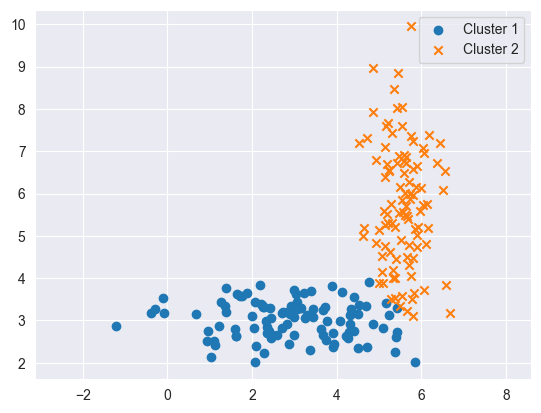

In [13]:
# Hard partition in 2-D without pCA
# 2 dimension plot
predicted_cluster1 = dataset[predicted_labels == 0][:, :-1]
predicted_cluster2 = dataset[predicted_labels == 1][:, :-1]
plt.clf()
plt.scatter(predicted_cluster1[:, 0], predicted_cluster1[:, 1], marker='o', label='Cluster 1')
plt.scatter(predicted_cluster2[:, 0], predicted_cluster2[:, 1], marker='x', label='Cluster 2')
# plt.xlabel('X-axis')
# plt.ylabel('Y-axis')
# plt.title('2D Dataset with two clusters - Wide x-Axis, Narrow y-Axis')
plt.legend()
plt.axis('equal')
plt.show()

[1, 77.8924912963464]
[2, 45.35362304062694]
[3, 27.98324754692727]
[4, 25.44845939143193]
[5, 25.18247602144012]
[6, 25.138362659768386]
[7, 25.125822268945253]
[8, 25.116550715931258]
[ 0.         25.11655072 25.11655072]
[1, 70.34075438311896]
[2, 57.98870737540856]
[3, 35.52024550139894]
[4, 29.767901711373263]
[5, 26.67019724172]
[6, 25.555007484998555]
[7, 25.262007052415942]
[8, 25.194193585855192]
[9, 25.167655617367892]
[10, 25.14875289018232]
[11, 25.13447274665459]
[12, 25.122958027051993]
[13, 25.113279800558377]
[ 1.        25.1132798 25.1132798]
[1, 65.61988035058482]
[2, 36.65351091079804]
[3, 26.968987854541226]
[4, 25.423155983548963]
[5, 25.191973009525068]
[6, 25.153676549137987]
[7, 25.13990711633857]
[8, 25.129150146571135]
[9, 25.119896668299493]
[ 2.         25.11989667 25.1132798 ]
[1, 75.10844993091861]
[2, 46.0378730383777]
[3, 28.95067425159789]
[4, 25.737622280320107]
[5, 25.232769782366862]
[6, 25.162136061654135]
[7, 25.14556237043132]
[8, 25.1338533601657

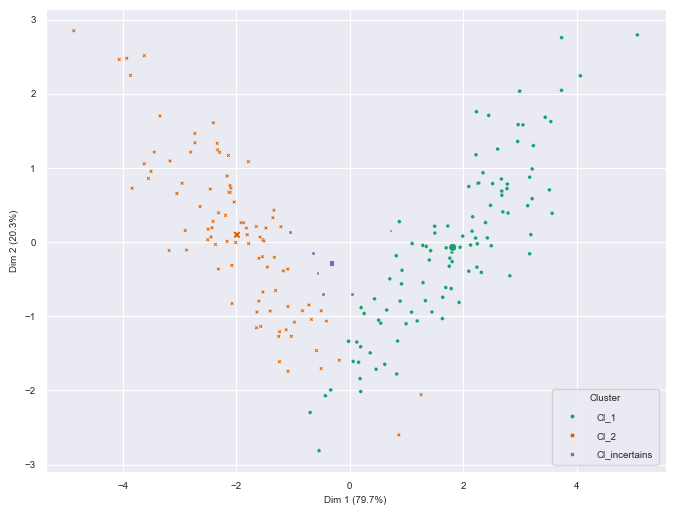

Adjusted Rand Index (ARI): 0.8456254898950312 - J value: 25.113279800558377
Silhouette Index (SI): 0.5203104053801421
Maximum Non-specificity value: 2.8838443541392067
Minimum Non-specificity value: 0.0021281099490188305
Average Non-specificity value: 0.6849768166798397


In [40]:
# Feature weighted ECM clustering
model = fwecm(x=df, c=2, beta=2, alpha=1, delta=100, ntrials=5)

# ev_plot(model, X=df)
ev_pcaplot(data=df, x=model, normalize=False)

# Compute the Adjusted Rand Index (ARI)
true_labels = dataset[:, -1]
Y_betP = model['betp']
predicted_labels = np.argmax(Y_betP, axis=1)

ari = adjusted_rand_score(true_labels, predicted_labels)
print(f"Adjusted Rand Index (ARI): {ari} - J value: {model['crit']}")

# Compute the Silhouette Index (SI)
si = silhouette_score(dataset[:, :-1], predicted_labels)
print(f"Silhouette Index (SI): {si}")

# Calculate Non-specificity
calculate_non_specificity(model)

# Hard partition in 2-D without PCA

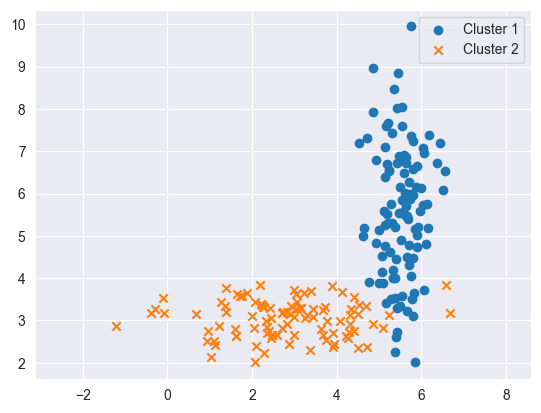

In [41]:
# Hard partition in 2-D without PCA
# 2 dimension plot
predicted_cluster1 = dataset[predicted_labels == 0][:, :-1]
predicted_cluster2 = dataset[predicted_labels == 1][:, :-1]
plt.clf()
plt.scatter(predicted_cluster1[:, 0], predicted_cluster1[:, 1], marker='o', label='Cluster 1')
plt.scatter(predicted_cluster2[:, 0], predicted_cluster2[:, 1], marker='x', label='Cluster 2')
# plt.xlabel('X-axis')
# plt.ylabel('Y-axis')
# plt.title('2D Dataset with two clusters - Wide x-Axis, Narrow y-Axis')
plt.legend()
plt.axis('equal')
plt.show()